# 환경 세팅 #

In [83]:
# import
import pyspark
from pyspark.sql import Row
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Spark
myConf = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
.builder\
.master('local')\
.appName('myApp')\
.config(conf=myConf)\
.getOrCreate()

21/11/04 01:26:50 WARN Utils: Your hostname, Kritiasui-MacBookAir.local resolves to a loopback address: 127.0.0.1; using 172.30.1.28 instead (on interface en0)
21/11/04 01:26:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/04 01:26:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [89]:
# Load Data
jfile = os.path.join('src', 'LandActualPriceInfo.json')
with open(jfile, 'rb') as f:
    data = f.readlines()
myData = json.loads(data[0])['landActualPriceInfo']['row']
type(myData)
myRdd = spark.sparkContext.parallelize(myData)
myRowRdd = myRdd.map(lambda x: Row(gu = x['SGG_NM'], area = float(x['BLDG_AREA']), cost = int(x['OBJ_AMT']), kind = x['BLDG_MUSE_NM']))
myDf = spark.createDataFrame(myRowRdd)
myDf.printSchema()

root
 |-- gu: string (nullable = true)
 |-- area: double (nullable = true)
 |-- cost: long (nullable = true)
 |-- kind: string (nullable = true)



21/11/04 03:28:42 WARN TaskSetManager: Stage 33 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


# 문제 설정 #

### 데이터셋: 서울특별시 부동산 실거래가 정보 ###
1. 가장 평균가격이 높은 구는 어디인가?
2. 건물 면적이 높은 부동산이 대체로 높은 가격에 거래되는가?

# 문제의 답 - 1 : 구 별로 거래 가격의 평균 군하기 #

In [103]:
result = myRowRdd.map(lambda ele: (ele['gu'], ele['cost']))\
    .combineByKey(lambda value: value,
    lambda x, value: x + value,
    lambda x, y: x + y)\
    .map(lambda ele : (ele[0], ele[1])).collect()
res = sorted(result, key = lambda element: -element[1])
np.vstack([res[:5], res[-5:]])

21/11/04 03:42:12 WARN TaskSetManager: Stage 58 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


array([['강남구', '250093600000'],
       ['송파구', '222419480000'],
       ['서초구', '179429500000'],
       ['강서구', '145742070000'],
       ['은평구', '127665300000'],
       ['광진구', '63614300000'],
       ['종로구', '62284380000'],
       ['강북구', '53090960000'],
       ['중랑구', '50056500000'],
       ['중구', '40565000000']], dtype='<U21')

위의 결과는 각 구의 거래가 평균을 구한 뒤, 가장 높은 5개의 구와 가장 낮은 5개의 구를 내림차순으로 정렬한 것이다.

결론: 거래가는 강남구, 송파구, 서초구 순으로 가장 높았고, 중구, 중랑구, 강북구 순으로 가장 낮았다.

# 문제의 답 - 2 : 건물 면적과 가격의 상관관계 분석하기

In [90]:
myDf.stat.corr('area',  'cost')

21/11/04 03:28:51 WARN TaskSetManager: Stage 34 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


0.6847272294054125

0.68의 상관관계를 가지고 있으므로, 실제로 가격은 건물의 면적이 높을 수록 완만하게 증가한다고 볼 수 있다. (양의 기울기를 가지기 때문)
추가로, 실제 데이터를 플롯해서 아래에 그려보겠다.

21/11/04 03:29:58 WARN TaskSetManager: Stage 41 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.
21/11/04 03:29:58 WARN TaskSetManager: Stage 42 contains a task of very large size (1264 KiB). The maximum recommended task size is 1000 KiB.


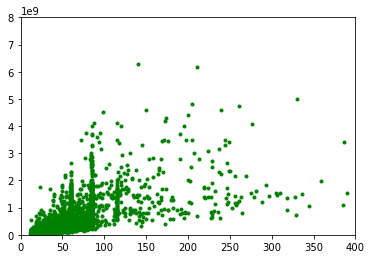

In [94]:
%matplotlib inline
area = np.array(myDf.rdd.map(lambda fields: fields[1]).collect())
cost = np.array(myDf.rdd.map(lambda fields: fields[2]).collect())

plt.plot(area, cost, 'g.')
plt.xlim((0, 400))
plt.ylim((0, 0.8e10))
plt.show()